<a href="https://colab.research.google.com/github/tommasomncttn/NAS4CNN/blob/main/notebook/Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing single CNN

### Importing 

In [1]:
!pip install torchview

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
import random
from torchview import draw_graph

### Dataset 

In [30]:
class TensorizedDigits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None, tensorized=True):
        digits = load_digits()

        # Split the dataset based on the mode
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)  # Get the first 1000 data samples
            self.targets = digits.target[:1000]  # Get the corresponding targets
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)  # Get the validation data samples
            self.targets = digits.target[1000:1350]  # Get the corresponding targets
        else:
            self.data = digits.data[1350:].astype(np.float32)  # Get the test data samples
            self.targets = digits.target[1350:]  # Get the corresponding targets

        self.transforms = transforms

        if tensorized:
            self.transforms = TensorizedDigits.tensorization_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]  # Get the data sample at the given index
        sample_y = self.targets[idx]  # Get the target at the given index
        
        if True:
            sample_x, sample_y = self.transforms(sample_x, sample_y)  # Apply the specified transforms

        return (sample_x, sample_y)

    @staticmethod
    def tensorization_transform(x, y):
        # Reshape the data sample to have a valid input shape for a CNN (Convolutional Neural Network)
        sample_x = x.reshape(1, 8, 8)
        sample_y = y

        # Transform the data sample to a torch tensor and move it to the GPU (if available)
        if torch.cuda.is_available():
            sample_x = torch.from_numpy(sample_x).to("cuda")
            sample_y = np.array(y)
            sample_y = torch.from_numpy(sample_y).to("cuda")

        return sample_x, sample_y
    
    def visualize_datapoint(self, idx):
        x, y = self.__getitem__(idx)  # Get the data sample and target at the given index
        plt.imshow(x[0].cpu(), cmap="gray")  # Display the data sample as an image
        plt.axis("off")
        plt.show()


### Module

In [27]:
import torch
import torch.nn as nn

class SingleConfigCNN(nn.Module):
    '''Conv2d → f(.) → Pooling → Flatten → Linear 1 → f(.) → Linear 2 → Softmax'''

    def __init__(self, cnn_i_N=1, cnn_o_N=8, cnn_k_size=3, stride=1, padding=1, pool_k_size=2, fnn_o_N=10):
        super(SingleConfigCNN, self).__init__()

        # Set the configuration parameters
        self.cnn_i_N = cnn_i_N
        self.cnn_o_N = cnn_o_N
        self.cnn_k_size = cnn_k_size
        self.stride = stride
        self.padding = padding
        self.pool_k_size = pool_k_size
        self.fnn_o_N = fnn_o_N

        # Define the layers of the CNN model
        self.cnn = nn.Conv2d(in_channels=cnn_i_N, out_channels=cnn_o_N, kernel_size=cnn_k_size, stride=stride, padding=padding)
        self.activation1 = nn.ReLU()  # Activation function after the convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=pool_k_size)  # Pooling layer
        self.flatten = nn.Flatten()  # Flatten the input for the fully connected layers

        self.linear1 = nn.Linear(in_features=self.compute_input_2_linear(), out_features=fnn_o_N)  # First fully connected layer
        self.activation2 = nn.ReLU()  # Activation function after the first fully connected layer
        self.linear2 = nn.Linear(in_features=fnn_o_N, out_features=10)  # Second fully connected layer
        self.softmax = nn.LogSoftmax(dim=1)  # Softmax activation for the final output

        self.nll = nn.NLLLoss(reduction="none")  # Negative log-likelihood loss

    def compute_input_2_linear(self):
        '''Compute the input size of the first fully connected layer based on the output of the previous layers.'''

        # Compute dimensions after convolution
        after_cnn_channels = self.cnn_o_N
        after_cnn_height = after_cnn_width = ((8 - self.cnn_k_size + 2 * self.padding) / self.stride) + 1

        # Compute dimensions after pooling
        after_pool_height = after_pool_width = ((after_cnn_height - self.pool_k_size) / self.pool_k_size) + 1

        # Compute input size after flattening
        return int(after_pool_height * after_pool_width * after_cnn_channels)

    def classify(self, log_prob):
        '''Classify samples based on the predicted log probabilities.'''

        y_pred = torch.argmax(log_prob, dim=1).long()
        return y_pred

    def forward(self, x):
        '''Forward pass through the CNN model.'''

        x = self.cnn(x)
        x = self.activation1(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.activation2(x)
        x = self.linear2(x)
        log_prob = self.softmax(x)

        return log_prob

    def compute_loss(self, log_prob, y, reduction="avg"):
        '''Compute the loss between predicted log probabilities and target labels.'''

        loss = self.nll(log_prob, y)

        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

    def count_misclassified(self, predictions, targets):
        '''Count the number of misclassified samples.'''

        e = 1.0 * (predictions == targets)
        misclassified = (1.0 - e).sum().item()

        return misclassified


### Training and Validation Loop

In [26]:
def configure_optimizer(model, lr=1e-3, wd=1e-5):
    # Configure the optimizer for the model using Adamax
    optimizer = torch.optim.Adamax(model.parameters(), lr=lr, weight_decay=wd)
    # Return the configured optimizer
    return optimizer


In [25]:
def train_one_epoch(dataloader, model, optimizer, epoch_n=None, is_silent=False):
    """
    Perform a single epoch of training on the provided dataloader.
    """
    model.train()  # Set the model to training mode

    size = len(dataloader.dataset)  # Total number of samples in the dataset
    total_loss = 0  # Accumulator for the total loss
    total_miss = 0  # Accumulator for the total number of misclassified samples
    train_step = 0  # Counter for the training steps

    for (X, y) in dataloader:
        train_step += 1

        log_prob = model(X)  # Compute the log probabilities (logits)

        predictions = model.classify(log_prob)  # Perform classification based on the predicted probabilities

        missclassified = model.count_misclassified(predictions, y)  # Count the number of misclassified samples
        total_miss += missclassified

        loss = model.compute_loss(log_prob, y, reduction="sum")  # Compute the loss
        total_loss += loss

        loss.backward()  # Backpropagation
        optimizer.step()  # Update the model's parameters
        optimizer.zero_grad()  # Clear the gradients

    avg_loss = total_loss / size  # Compute the average training loss
    avg_ce = total_miss / size  # Compute the average classification error

    if not is_silent:
        print("")
        print(f" TRAINING => Results of epoch number {epoch_n}:")
        print("")
        print("    Average training loss: {0:.5f}".format(avg_loss))
        print("    Average training classification error: {0:.5f}".format(avg_ce))

    return avg_loss.item(), avg_ce


In [24]:
def evaluation_one_epoch(dataloader, model, optimizer, mode="validation", epoch_n=None, is_silent=False):
    """
    Perform a single epoch of evaluation on the provided dataloader.

    """
    model.eval()  # Set the model to evaluation mode

    size = len(dataloader.dataset)  # Total number of samples in the dataset
    total_loss = 0  # Accumulator for the total loss
    total_miss = 0  # Accumulator for the total number of misclassified samples
    val_step = 0  # Counter for the evaluation steps

    with torch.no_grad():  # Disable gradient calculation during evaluation
        for (X, y) in dataloader:
            val_step += 1

            log_prob = model(X)  # Compute the log probabilities (logits)

            predictions = model.classify(log_prob)  # Perform classification based on the predicted probabilities

            missclassified = model.count_misclassified(predictions, y)  # Count the number of misclassified samples
            total_miss += missclassified

            loss = model.compute_loss(log_prob, y, reduction="sum")  # Compute the loss
            total_loss += loss

    avg_loss = total_loss / size  # Compute the average evaluation loss
    avg_ce = total_miss / size  # Compute the average classification error

    if not is_silent:
        if mode == "validation":
            print("")
            print("    Average validation loss: {:.5f}".format(avg_loss))
            print("    Average validation classification error: {:.5f}".format(avg_ce))
        else:
            print("")
            print("TESTING => Results over the test set")
            print("")
            print("    Average test loss: {:.5f}".format(avg_loss))
            print("    Average test classification error: {:.5f}".format(avg_ce))

    return avg_loss.item(), avg_ce


In [23]:
def fit_epochs(training_loader, val_loader, test_loader, model, optimizer, n_epochs, test_model=True, is_silent=False):
    """
    Train the model for the specified number of epochs and evaluate it on the validation and test datasets.

    Args:
        training_loader: The dataloader for the training dataset.
        val_loader: The dataloader for the validation dataset.
        test_loader: The dataloader for the test dataset.
        model: The model to be trained and evaluated.
        optimizer: The optimizer for updating model parameters during training.
        n_epochs (int): The number of epochs to train the model.
        test_model (bool): Whether to evaluate the model on the test dataset (optional).
        is_silent (bool): Whether to print training and evaluation results (optional).

    Returns:
        dict: A dictionary containing the training and evaluation results.

    """
    train_loss_list = []  # List to store training losses for each epoch
    train_ce_list = []  # List to store training classification errors for each epoch
    val_loss_list = []  # List to store validation losses for each epoch
    val_ce_list = []  # List to store validation classification errors for each epoch
    test_loss_result = []  # List to store test loss (if test_model is True)
    test_ce_result = []  # List to store test classification error (if test_model is True)

    for i in range(n_epochs):
        # Training phase
        train_loss, train_ce = train_one_epoch(dataloader=training_loader, model=model, optimizer=optimizer,
                                               epoch_n=i, is_silent=is_silent)
        train_loss_list.append(train_loss)
        train_ce_list.append(train_ce)

        # Validation phase
        val_loss, val_ce = evaluation_one_epoch(dataloader=val_loader, model=model, optimizer=optimizer,
                                                epoch_n=i, is_silent=is_silent)
        val_loss_list.append(val_loss)
        val_ce_list.append(val_ce)

    if test_model:
        # Testing phase
        test_loss, test_ce = evaluation_one_epoch(dataloader=test_loader, model=model, optimizer=optimizer,
                                                  mode="test", epoch_n=i, is_silent=is_silent)
        test_loss_result.append(test_loss)
        test_ce_result.append(test_ce)

        result_dic = {
            "train_loss_list": train_loss_list,
            "train_ce_list": train_ce_list,
            "val_loss_list": val_loss_list,
            "val_ce_list": val_ce_list,
            "test_loss_result": test_loss_result,
            "test_ce_result": test_ce_result,
            "number_of_epochs": n_epochs
        }
    else:
        result_dic = {
            "train_loss_list": train_loss_list,
            "train_ce_list": train_ce_list,
            "val_loss_list": val_loss_list,
            "val_ce_list": val_ce_list,
            "number_of_epochs": n_epochs
        }

    return result_dic


In [22]:
def plot_results(results):
    # Extracting the data from the dictionary
    train_loss_list = results["train_loss_list"]
    train_ce_list = results["train_ce_list"]
    val_loss_list = results["val_loss_list"]
    val_ce_list = results["val_ce_list"]
    test_loss_result = results["test_loss_result"]
    test_ce_result = results["test_ce_result"]
    n_epochs = results["number_of_epochs"]

    # Plotting losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, n_epochs + 1), train_loss_list, label="Train Loss")
    plt.plot(range(1, n_epochs + 1), val_loss_list, label="Validation Loss")
    plt.plot(range(1, n_epochs + 1), [test_loss_result] * n_epochs, label="Test Loss", linestyle="--")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Evaluation Losses")
    plt.legend()

    # Plotting classification errors
    plt.subplot(1, 2, 2)
    plt.plot(range(1, n_epochs + 1), train_ce_list, label="Train Classification Error")
    plt.plot(range(1, n_epochs + 1), val_ce_list, label="Validation Classification Error")
    plt.plot(range(1, n_epochs + 1), [test_ce_result] * n_epochs, label="Test Classification Error", linestyle="--")
    plt.xlabel("Epochs")
    plt.ylabel("Classification Error")
    plt.title("Training and Evaluation Classification Errors")
    plt.legend()

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


# Implementing Multiple CNN

### Multi Module

In [21]:
import torch
import torch.nn as nn

class MultiConfigCNN(nn.Module):
    '''Conv2d → f(.) → Pooling → Flatten → Linear 1 → f(.) → Linear 2 → Softmax'''

    def __init__(self, config, cnn_i_N=1, pool_k_size=2, fnn_o_N=10):
        super(MultiConfigCNN, self).__init__()

        self.config = config 

        # Set the values from the config dictionary
        self.cnn_i_N = cnn_i_N  # Number of input channels for the convolutional layer
        self.cnn_o_N = self.config["conv_filters"]  # Number of output channels for the convolutional layer
        self.cnn_k_size = self.config["cnn_architectures"]["kernel_size"]  # Kernel size for the convolutional layer
        self.stride = self.config["cnn_architectures"]["stride"]  # Stride for the convolutional layer
        self.padding = self.config["cnn_architectures"]["padding"]  # Padding for the convolutional layer
        self.pool_k_size = self.config["pooling"]["kernel_size"]  # Kernel size for pooling
        self.fnn_o_N = self.config["linear_1_neurons"]  # Number of neurons in the first linear layer
        self.pooling_type = self.config["pooling"]["pooling_type"]  # Type of pooling (Average or Maximum)

        # Define the layers
        self.cnn = nn.Conv2d(in_channels=cnn_i_N, out_channels=self.cnn_o_N, kernel_size=self.cnn_k_size, stride=self.stride, padding=self.padding)  # Convolutional layer
        self.activation1 = self.config["activation"]  # Activation function for the convolutional layer

        # Choose the pooling type based on the config
        if self.pooling_type != "Average":
            self.pool = nn.MaxPool2d(kernel_size=self.pool_k_size)  # Max pooling layer
        else:
            self.pool = nn.AvgPool2d(kernel_size=self.pool_k_size)  # Average pooling layer

        self.flatten = nn.Flatten()  # Flatten the output

        self.linear1 = nn.Linear(in_features=self.compute_input_2_linear(), out_features=self.fnn_o_N)  # First linear layer
        self.activation2 = self.config["activation"]  # Activation function for the first linear layer
        self.linear2 = nn.Linear(in_features=self.fnn_o_N, out_features=10)  # Second linear layer
        self.softmax = nn.LogSoftmax(dim=1)  # Softmax function

        self.nll = nn.NLLLoss(reduction="none")  # Negative log-likelihood loss function

    def compute_input_2_linear(self):
        # Compute the size after convolution
        after_cnn_channels = self.cnn_o_N
        after_cnn_height = after_cnn_width = ((8 - self.cnn_k_size + 2 * self.padding) / self.stride) + 1

        # Compute the size after pooling
        after_pool_height = after_pool_width = ((after_cnn_height - self.pool_k_size) / self.pool_k_size) + 1

        # Compute the size after flattening
        return int(after_pool_height * after_pool_width * after_cnn_channels)

    def classify(self, log_prob):
        # Classify by taking the argmax of the log probabilities
        y_pred = torch.argmax(log_prob, dim=1).long()
        return y_pred

    def forward(self, x):
        # Forward pass through the network
        x = self.cnn(x)
        x = self.activation1(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.activation2(x)
        x = self.linear2(x)
        log_prob = self.softmax(x)

        return log_prob

    def compute_loss(self, log_prob, y, reduction="avg"):
        # Compute the loss using negative log likelihood loss
        loss = self.nll(log_prob, y)

        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

    def count_misclassified(self, predictions, targets):
        # Count the number of misclassified samples
        e = 1.0 * (predictions == targets)
        misclassified = (1.0 - e).sum().item()

        return misclassified

    @staticmethod
    def possible_config():
        # Return the possible configurations for the model
        possible_config = {
            "conv_filters": [8, 16, 32],
            "cnn_architectures": [
                {"kernel_size": 3, "stride": 1, "padding": 1},
                {"kernel_size": 5, "stride": 1, "padding": 2}
            ],
            "activation": [nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.Softplus(), nn.ELU],
            "pooling": [
                {"kernel_size": 2, "pooling_type": "Average"},
                {"kernel_size": 2, "pooling_type": "Maximum"},
                {"kernel_size": 1, "pooling_type": "Average"},
                {"kernel_size": 1, "pooling_type": "Maximum"}
            ],
            "linear_1_neurons": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        }
        return possible_config


# Evolutionary Algorithm 

### Utils for EA

In [20]:
import random
import torch.nn as nn

class Utils4EA():
    def __init__(self):
        pass

    @staticmethod
    def check_validity_genotype(input_list):
        # Define the lengths of the sublists
        list_lengths = [3, 2, 5, 4, 10]

        # Check if the length of the input list matches the sum of the sublist lengths
        if len(input_list) != sum(list_lengths):
            return False

        index = 0
        for length in list_lengths:
            # Extract a sublist from the input list
            sublist = input_list[index:index+length]

            # Generate a list of valid values for the sublist
            sampled_values = list(range(length))

            # Check if all values in the sublist are valid
            if not all(value in sampled_values for value in sublist):
                return False

            index += length

        return True

    @staticmethod
    def generate_random_genotype():
        # Define the lengths of the sublists
        list_lengths = [3, 2, 5, 4, 10]
        random_list = []

        for length in list_lengths:
            # Randomly select an element from the sublist
            sublist = random.sample(range(length), 1)
            random_list.extend(sublist)

        return random_list

    @staticmethod
    def generate_random_phenotype():
        # Define the possible values for each genotype component
        genotype = {
            "conv_filters": random.choice([8, 16, 32]),
            "cnn_architecture": random.choice([
                {"kernel_size": 3, "stride": 1, "padding": 1},
                {"kernel_size": 5, "stride": 1, "padding": 2}
            ]),
            "activation": random.choice([nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.Softplus(), nn.ELU()]),
            "pooling": random.choice([
                {"kernel_size": 2, "pooling_type": "Average"},
                {"kernel_size": 2, "pooling_type": "Maximum"},
                {"kernel_size": 1, "pooling_type": "Average"},
                {"kernel_size": 1, "pooling_type": "Maximum"}
            ]),
            "linear_1_neurons": random.choice([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
        }
        return genotype

    @staticmethod
    def genotype_space():
        # Define the genotype space
        genotype_space = {}
        for key, value in Utils4EA().phenotype_space().items():
            # Determine the length of each genotype component
            value_length = len(value)
            # Create a range of indices representing the possible values for the component
            dimension_space = range(0, value_length)
            genotype_space[key] = dimension_space

        return genotype_space

    @staticmethod
    def genotype_space_bounds():
        # Create a list of ranges representing the bounds of the genotype space
        sampling_space = []
        for key, value in Utils4EA.genotype_space().items():
            sampling_space.append(value)
        return sampling_space

    @staticmethod
    def phenotype_space():
        # Define the possible configurations for the model
        possible_config = {
            "conv_filters": [8, 16, 32],
            "cnn_architectures": [
                {"kernel_size": 3, "stride" : 1, "padding" : 1},
                {"kernel_size": 5, "stride" : 1, "padding" : 2}
            ],
            "activation": [nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.Softplus(), nn.ELU()],
            "pooling": [
                {"kernel_size": 2, "pooling_type": "Average"},
                {"kernel_size": 2, "pooling_type": "Maximum"},
                {"kernel_size": 1, "pooling_type": "Average"},
                {"kernel_size": 1, "pooling_type": "Maximum"}
            ],
            "linear_1_neurons": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        }
        return possible_config


### EA

In [19]:
class EA(object):
    def __init__(self, pop_size=20, lAmbda=0.01, n_epochs=10, p_selection_percentage=0.95):
        # Constructor
        # Load the constructor parameters as attributes
        self.pop_size = pop_size
        self.lAmbda = lAmbda
        self.max_num_param = 206742
        self.n_epochs = n_epochs
        self.parent_selection_percentage = p_selection_percentage

        # Define the genotypespace TODO
        self.gene_bounds = Utils4EA.genotype_space_bounds()

        # Dataset and dataloader
        self.train_data = TensorizedDigits(mode="train")
        self.val_data = TensorizedDigits(mode="val")
        self.test_data = TensorizedDigits(mode="test")
        self.training_loader = DataLoader(self.train_data, batch_size=64, shuffle=True)
        self.val_loader = DataLoader(self.val_data, batch_size=64, shuffle=False)
        self.test_loader = DataLoader(self.test_data, batch_size=64, shuffle=False)

    # -------
    # FOR NN
    # -------

    def evaluate(self, x):
        # Function to evaluate a list of models (x)
        fitness_list = []
        for model in x:
            # Configure optimizer
            opt = configure_optimizer(model)
            
            # Fit epochs
            results = fit_epochs(
                self.training_loader,
                self.val_loader,
                self.test_loader,
                model=model,
                optimizer=opt,
                n_epochs=self.n_epochs,
                test_model=False,
                is_silent=True
            )

            num_params = sum(p.numel() for p in model.parameters())
            if num_params > self.max_num_param:
                print(num_params)
                print(model)
                raise ValueError("Compute again, unbeliavable shame")
            
            fitness = results["val_ce_list"][-1] + self.lAmbda * (num_params / self.max_num_param)
            fitness_list.append(fitness)
        
        return fitness_list

    def config_from_single_genotype(self, genotype):
        # Function to generate phenotype config from a single genotype
        # Checking genotype validity
        is_valid = Utils4EA.check_validity_genotype(genotype)
        # if not(is_valid):
        #     raise ValueError("Invalid Genotype")

        # Importing phenotype space
        phenotypespace = Utils4EA.phenotype_space()

        # Get the phenotype configuration
        phenotype_config = {
            "conv_filters": phenotypespace["conv_filters"][genotype[0]],
            "cnn_architectures": phenotypespace["cnn_architectures"][genotype[1]],
            "activation": phenotypespace["activation"][genotype[2]],
            "pooling": phenotypespace["pooling"][genotype[3]],
            "linear_1_neurons": phenotypespace["linear_1_neurons"][genotype[4]]
        }
        return phenotype_config

    def encoding_population(self, genotypes):
        # Function to encode a list of genotypes into phenotypes
        phenotypes = []
        for genotype in genotypes:
            phenotype_config = self.config_from_single_genotype(genotype)
            phenotype = MultiConfigCNN(phenotype_config)
            phenotypes.append(phenotype)
        return phenotypes

    # -------
    # FOR EVOLUTIONARY ALGORITHM
    # -------

    def parent_selection(self, x_old, f_old):
        '''Function to select a subset of individuals from x_old as the parent population
        for breeding the new candidate solutions'''

        x_old = np.array(x_old)
        f_old = np.array(f_old)

        # Get the size of the parent population based on the percentage given
        parent_size = int(len(x_old) * self.parent_selection_percentage)

        # Randomly select individuals for parent population
        parent_indices = np.random.choice(len(x_old), size=parent_size, replace=False)
        x_parents = x_old[parent_indices]
        f_parents = f_old[parent_indices]

        # Return the selected parents
        return x_parents.tolist(), f_parents.tolist()

    def recombination(self, x_parents, f_parents):
        '''First step in working out the candidate solutions, we pass from the
        selected parents to a set of INITIAL candidate solutions'''

        # Initialize an empty list to store recombined parents
        x_recombined_parents = []

        # Loop for half of the population size
        for i in range(self.pop_size // 2):
            # Pick two random indices
            idx = np.random.choice(len(x_parents), size=2, replace=False)

            # Get the corresponding elements from the array
            pair = (x_parents[idx[0]], x_parents[idx[1]])

            # Select a random point on the lists
            index = random.randrange(len(pair[0]))

            # Recombine them with one-point crossover
            if index != 0:
                recombined_parent_1 = [*pair[0][:index], *pair[1][index:]]
                recombined_parent_2 = [*pair[1][:index], *pair[0][index:]]
            else:
                recombined_parent_1 = [pair[0][0], *pair[1][1:]]
                recombined_parent_2 = [pair[1][0], *pair[0][1:]]

            # Append to the new list
            x_recombined_parents.append(recombined_parent_1)
            x_recombined_parents.append(recombined_parent_2)

        # Convert the list to a numpy array
        x_recombined_parents_array = np.stack(x_recombined_parents)

        # Return the recombined parents array
        return x_recombined_parents_array

    def mutation(self, x_children):
        # Mutation step
        # Initialize mutated_children list
        mutated_children = []

        # Repeat for each solution in the set of candidate solutions
        for x_current in x_children:
            index = random.randrange(len(x_current))
            sampling_range = self.gene_bounds[index]
            random_mutation = random.choice(sampling_range)
            x_current[index] = random_mutation
            mutated_children.append(x_current)

        # Convert the list to a NumPy array of arrays
        mutated_children_array = np.stack(mutated_children)

        # Return the final candidate solutions
        return mutated_children_array

    def survivor_selection(self, x_parents_geno, x_children_geno, f_parents, f_children):
        '''We pass from a set of FINAL candidate solutions to the new population
        by selecting the best individuals'''

        # Concatenate miu and lambda, old population and candidate solutions
        x = np.concatenate([x_parents_geno, x_children_geno])

        # Concatenate their fitness
        f = np.concatenate([f_parents, f_children])

        # Sort them, the lefter the better
        index = np.argsort(f)
        x = x[index]
        f = f[index]

        # Return only the best pop size (miu)
        return x[:self.pop_size], f[:self.pop_size]

    # -------
    # STEP
    # -------

    def step(self, x_parents_geno, f_parents):
        # Perform a single step of the evolutionary algorithm

        # Parent selection
        x_parents_geno, f_parents = self.parent_selection(x_parents_geno, f_parents)

        # Recombination step
        x_children_geno = self.recombination(x_parents_geno, f_parents)

        # Mutation step
        x_children_geno = self.mutation(x_children_geno)

        # Encoding step
        x_children_pheno = self.encoding_population(x_children_geno)

        # Evaluation step
        f_children = self.evaluate(x_children_pheno)

        # Survivor selection
        x, f = self.survivor_selection(x_parents_geno, x_children_geno, f_parents, f_children)

        return x, f


### Optimizer

In [18]:
class Optimizer:

  def __init__(self, generation=50, pop_size=20, n_epochs_generation=10, lAmbda=0.01, epochs_best_model=10):
    # Initialize the optimizer with specified parameters
    self.generation = generation  # generation for which to run the EA
    self.pop_size = pop_size  # population size of the EA
    self.n_epochs_generation = n_epochs_generation  # number of epochs to train each solution
    self.lAmbda = lAmbda  # scaling factor of the fitness function
    self.epochs_best_model = epochs_best_model  # number of epochs to train the best solution for final evaluation
    self.ea = EA(pop_size=self.pop_size, n_epochs=self.n_epochs_generation, lAmbda=self.lAmbda)  # instance of the EA

  def n_generation(self):
    # Perform the EA for a specified number of generations

    # Initialize the genotype population
    x_geno = []
    for i in range(0, self.pop_size):
      genotype = Utils4EA.generate_random_genotype()
      x_geno.append(genotype)

    # Convert genotypes to phenotypes and evaluate their objective function
    x_pheno = self.ea.encoding_population(x_geno)
    f = self.ea.evaluate(x_pheno)

    num_generations = self.generation
    pop_size = self.pop_size

    f_best = [np.array(f).min()]  # Store the best objective value at each generation
    f_history = [np.array(f).min()]  # Store the minimum objective value at each generation
    x_best = x_geno[np.array(f).argmin()]  # Store the best genotype
    visual_range = tqdm(range(num_generations))  # Create a progress bar for visualization
    for i in visual_range:
      print("Generation: {}, best objective: {:.5f}".format(i, np.array(f).min()))
      x_geno, f = self.ea.step(x_geno, f)  # Perform a single step of the EA
      f_history.append(np.array(f).min())
      if np.array(f).min() < f_best[-1]:
          f_best.append(np.array(f).min())
          x_best = x_geno[np.array(f).argmin()]  # Update the best genotype
      else:
          f_best.append(f_best[-1])  # Keep the previous best objective value if there is no improvement
      visual_range.set_postfix({f'best objective score at generation {i} ': f_best[-1]})
    visual_range.close()
    print("FINISHED!")
    print("best", f_best)
    print("story", f_history)
    return f_best, x_best, f_history

  def printout_best_genotype(self, x_best):
    # Print out the best genotype, phenotype configuration, and visual graph of the model

    genotype = x_best
    phenotype_config = self.ea.config_from_single_genotype(genotype)
    phenotype = MultiConfigCNN(phenotype_config)
    input = next(iter(self.ea.training_loader))[0]
    model_graph = draw_graph(phenotype, input_data=input)
    print("\033[31mBEST GENOTYPE :", "\033[0m")
    print("")
    print("==>", x_best)
    print("")
    print("")
    print("\033[31mITS PHENOTYPE CONFIGURATION:", "\033[0m")
    print("")
    print("==>", phenotype_config)
    print("")
    print("")
    print("\033[31mBEST VISUAL OF THE MODEL", "\033[0m")
    print("")

    return model_graph.visual_graph

  def plot_obj(self, f_best, f_history):
    # Plot the progression of the objective function over generations

    generations = range(1, len(f_best) + 1)

    plt.plot(generations, f_best, label='Global Best')
    plt.plot(generations, f_history, label='Local Best')

    plt.xlabel('Generation')
    plt.ylabel('Objective')
    plt.title('Objective Progression')
    plt.legend()
    plt.grid(True)

    plt.show()

  def train_and_test_selected_genotype(self, x_best):
    # Train and test the selected best genotype

    genotype = x_best
    phenotype_config = self.ea.config_from_single_genotype(genotype)
    phenotype = MultiConfigCNN(phenotype_config)
    opt = configure_optimizer(phenotype)
    results = fit_epochs(self.ea.training_loader, self.ea.val_loader, self.ea.test_loader, model=phenotype, optimizer=opt,
                         n_epochs=self.epochs_best_model)

    return results

  def print_results_of_model(self, results):
    # Print the results of the trained model

    print("TEST CE: ", results["test_ce_result"])
    print("TEST LOSS: ", results["test_loss_result"])

    plot_results(results)

  def analysis(self):
    # Perform the analysis consisting of multiple steps

    print("")
    print("")
    print("\033[2J\033[\033[1m" + "Analysis 1: generations" + "\033[0m")
    print("")
    print("")
    f_best, x_best, f_history = self.n_generation()
    print("")
    print("")
    print("\033[2J\033[\033[1m" + "Analysis 2: results of generation in terms of objective" + "\033[0m")
    print("")
    print("")
    self.plot_obj(f_best, f_history)
    print("")
    print("")
    print("\033[2J\033[\033[1m" + "Analysis 3: training and testing best genotype" + "\033[0m")
    print("")
    print("")
    results = self.train_and_test_selected_genotype(x_best)
    print("")
    print("")
    print("\033[2J\033[\033[1m" + "Analysis 4: results of best phenotype in terms of loss and classification error" + "\033[0m")
    print("")
    print("")
    self.print_results_of_model(results)
    print("")
    print("")
    print("\033[2J\033[\033[1m" + "Analysis 5: printing out best genotype, phenotype configuration, and phenotype" + "\033[0m")
    print("")
    print("")
    return self.printout_best_genotype(x_best)


# Analysis And Inference



[Analysis 1: generations




  0%|          | 0/50 [00:00<?, ?it/s]

Generation: 0, best objective: 0.02700
Generation: 1, best objective: 0.02651
Generation: 2, best objective: 0.02651
Generation: 3, best objective: 0.02404
Generation: 4, best objective: 0.02404
Generation: 5, best objective: 0.02404
Generation: 6, best objective: 0.02404
Generation: 7, best objective: 0.02404
Generation: 8, best objective: 0.02204
Generation: 9, best objective: 0.02204
Generation: 10, best objective: 0.02204
Generation: 11, best objective: 0.02204
Generation: 12, best objective: 0.01918
Generation: 13, best objective: 0.01918
Generation: 14, best objective: 0.01918
Generation: 15, best objective: 0.01918
Generation: 16, best objective: 0.01918
Generation: 17, best objective: 0.01918
Generation: 18, best objective: 0.01918
Generation: 19, best objective: 0.01918
Generation: 20, best objective: 0.01918
Generation: 21, best objective: 0.01918
Generation: 22, best objective: 0.01918
Generation: 23, best objective: 0.01918
Generation: 24, best objective: 0.01918
Generation

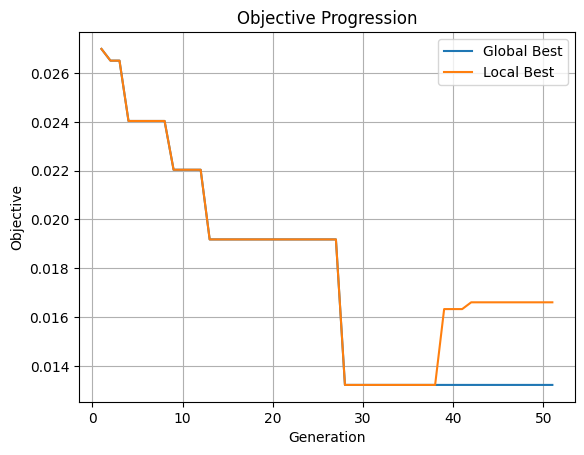



[Analysis 3: training and testing best genotype



 TRAINING => Results of epoch number 0:

    Average training loss: 1.54799
    Average training classification error: 0.45200

    Average validation loss: 0.90102
    Average validation classification error: 0.14000

 TRAINING => Results of epoch number 1:

    Average training loss: 0.71673
    Average training classification error: 0.12700

    Average validation loss: 0.48271
    Average validation classification error: 0.07429

 TRAINING => Results of epoch number 2:

    Average training loss: 0.43018
    Average training classification error: 0.07200

    Average validation loss: 0.35165
    Average validation classification error: 0.06571

 TRAINING => Results of epoch number 3:

    Average training loss: 0.29276
    Average training classification error: 0.04800

    Average validation loss: 0.25947
    Average validation classification error: 0.04857

 TRAINING => Results of epoch number 4:

    Average training loss: 0.

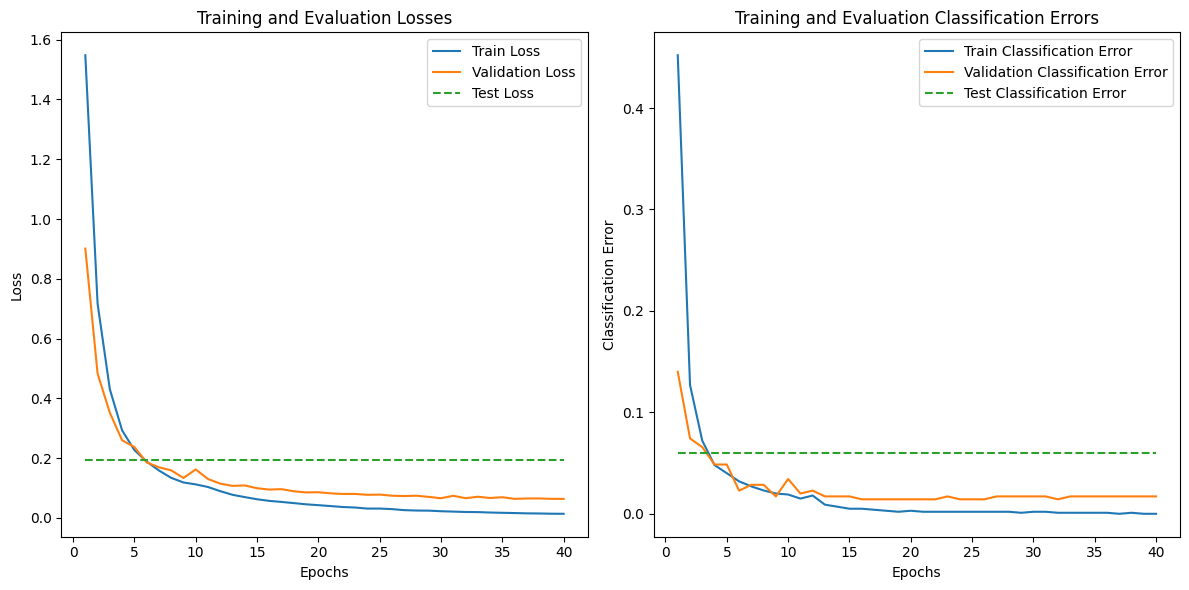



[Analysis 5: printing out best genotype, phenotype configuration, and phenotype


BEST GENOTYPE : 

==> [2 0 0 1 6]


ITS PHENOTYPE CONFIGURATION: 

==> {'conv_filters': 32, 'cnn_architectures': {'kernel_size': 3, 'stride': 1, 'padding': 1}, 'activation': ReLU(), 'pooling': {'kernel_size': 2, 'pooling_type': 'Maximum'}, 'linear_1_neurons': 70}


BEST VISUAL OF THE MODEL 



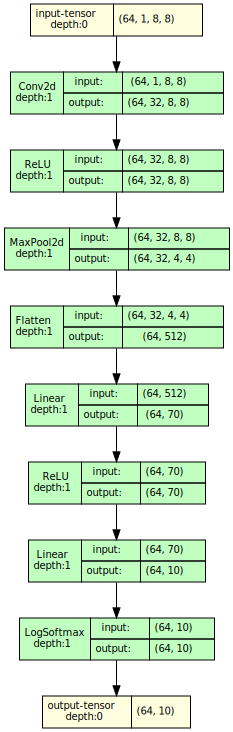

In [31]:
ot = Optimizer(generation = 50, pop_size = 20, n_epochs_generation = 8, lAmbda =0.01, epochs_best_model = 40)
ot.analysis()

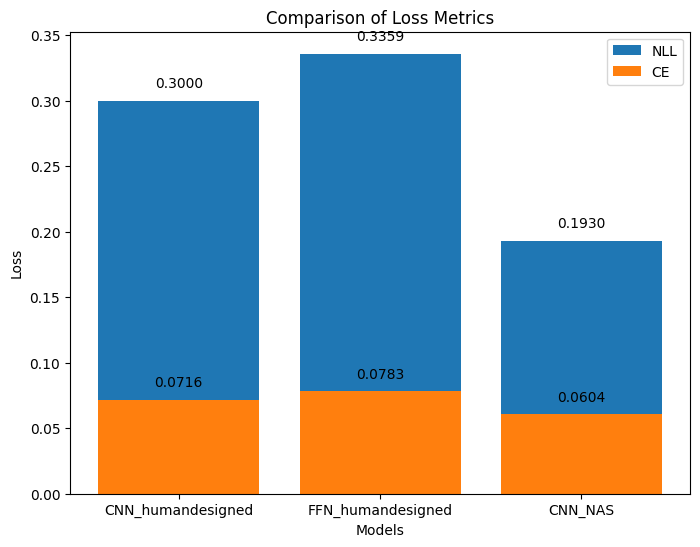

In [34]:
import matplotlib.pyplot as plt

# Data
models = ['CNN_humandesigned', 'FFN_humandesigned', 'CNN_NAS']
nll_values = [0.3, 0.3359288774614099, 0.193]
ce_values = [0.0716, 0.07829977628635347, 0.0604]

# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, nll_values, label='NLL')
plt.bar(models, ce_values, label='CE')
plt.xlabel('Models')
plt.ylabel('Loss')
plt.title('Comparison of Loss Metrics')

# Add numeric values on the bars
for i in range(len(models)):
    plt.text(models[i], nll_values[i] + 0.01, f"{nll_values[i]:.4f}", ha='center')
    plt.text(models[i], ce_values[i] + 0.01, f"{ce_values[i]:.4f}", ha='center')

plt.legend()
plt.show()
